# Model1

## Data


In [1]:
import pandas as pd

# Sea
sample_path = "../merged_output/se/20201201se.csv.csv"
origin_df = pd.read_csv(sample_path)
sea_df_all = origin_df[origin_df['depth'] < 500]
sea_df = sea_df_all[['depth', 'lat', 'lon', 'uo', 'vo', 'thetao', 'so']]

g_0 = 9.8009

# submersible
M_empty = 9000  # kg
length = 6.5  # m
width = 3.27  # m
height = 2.14  # m

lat lon -> y,x


In [3]:
import numpy as np
from geopy.distance import geodesic


def calc_xy(lat1, lon1, lat2, lon2):
    coor1 = (lat1, lon1)
    coor2 = (lat1, lon2)
    coor3 = (lat2, lon1)
    x = geodesic(coor1, coor2).meters
    y = geodesic(coor1, coor3).meters
    x = 0 if np.isnan(x) else x
    y = 0 if np.isnan(y) else y
    return x, y


def add_xy(df, origin=None):
    if origin:
        rlat, rlon = origin
    else:
        rlat = df['lat'].min()
        rlon = df['lon'].min()

    # Calculate 'x' and 'y' for each row in the DataFrame
    for index, row in df.iterrows():
        x, y = calc_xy(rlat, rlon, row['lat'], row['lon'])
        df.at[index, 'x'] = x
        df.at[index, 'y'] = y


add_xy(sea_df)
sea_df.head()

,depth,lat,lon,uo,vo,thetao,so,x,y
0,1.018237,37.395832,20.583334,0.064619,0.204145,19.271963,39.121536,0.000000,0.0
1,1.018237,37.395832,20.625000,0.061114,0.207258,19.492313,39.208515,3689.449295,0.0
2,1.018237,37.395832,20.666666,0.056907,0.200960,19.731630,39.298695,7378.898409,0.0
3,1.018237,37.395832,20.708334,0.054610,0.186794,19.889189,39.353320,11068.516056,0.0
4,1.018237,37.395832,20.750000,0.054155,0.165965,19.972195,39.377823,14757.964271,0.0


## Pressure & Density


In [4]:
def ini_density(s, t):
    def reference_density(t):
        a0_star = 999.842594
        a1 = 6.793952e-02
        a2 = -9.095290e-03
        a3 = 1.001685e-04
        a4 = -1.120083e-06
        a5 = 6.536332e-09

        return a0_star + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5

    b0 = 8.24493E-1
    b1 = -4.0899E-3
    b2 = 7.6438E-5
    b3 = -8.2467E-7
    b4 = 5.3875E-9

    c0 = 5.72466E-3
    c1 = 1.0227E-4
    c2 = -1.6546E-6

    d0 = 4.8314E-4

    rho_w_star = reference_density(t)

    return rho_w_star + (b0 + b1*t + b2*t**2 + b3*t**3 + b4*t**4) * s \
        + (c0 + c1*t + c2*t**2) * s**(3/2) \
        + d0 * s**2


def k_sbm(s, t, p):
    def k_st0(s, t):
        def k_w(t):
            e0 = 19652.21
            e1 = 148.4206
            e2 = -2.327105
            e3 = 0.01360477
            e4 = -0.00005155288

            # Calculate K_w using the provided equation
            K_w = e0 + e1 * t + e2 * t**2 + e3 * t**3 + e4 * t**4

            return K_w

        f0 = 54.6746
        f1 = -0.603459
        f2 = 1.09987E-02
        f3 = -6.16700E-05

        g0 = 7.944E-02
        g1 = 1.64830E-02
        g2 = -5.30900E-04

        K_w = k_w(t)
        K0 = K_w + (f0 + f1 * t + f2 * t**2 + f3 * t**3) * \
            s + (g0 + g1 * t + g2 * t**2)**(3/2)

        return K0

    def calc_A(s, t):
        def calc_A_w(t):
            h0 = 3.239908
            h1 = 1.43713E-3
            h2 = 1.16092E-4
            h3 = -5.77905E-7

            A_w = h0 + h1 * t + h2 * t**2 + h3 * t**3

            return A_w

        i0 = 2.2838E-3
        i1 = -1.0981E-5
        i2 = -1.6078E-6
        j0 = 1.91075E-4

        A = calc_A_w(t) + (i0 + i1 * t + i2 * t**2) * s + j0 * s**(3/2)

        return A

    def calc_B(s, t):
        def calc_B_w(t):
            k0_star = 8.50935E-5
            k1 = -6.12293E-6
            k2 = 5.2787E-8

            B_w = k0_star + k1 * t + k2 * t**2

            return B_w

        m0 = -9.9348E-7
        m1 = 2.0816E-8
        m2 = 9.1697E-10

        B = calc_B_w(t) + (m0 + m1 * t + m2 * t**2) * s

        return B

    K = k_st0(s, t) + calc_A(s, t)*p + calc_B(s, t)*p**2
    return K


# USE THIS to calculate density
def density(s, t, p):
    return ini_density(s, t)/(1-p/k_sbm(s, t, p))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

s = 40
t = 10

# Create an array of pressure values over which you want to evaluate the density function
pressure_values = np.linspace(0, 2, 1000)

# Calculate density for each pressure value
density_values = [density(s, t, p) for p in pressure_values]

# Plot density vs pressure
plt.plot(pressure_values, density_values)
plt.ylabel('Pressure')
plt.xlabel('Density')
plt.title('Density vs Pressure')
plt.grid(True)
plt.show()

### Regression of s(z) and t(z)


In [6]:
from pycaret.regression import RegressionExperiment

s_df = sea_df[['depth', 'x', 'y', 'so']]
t_df = sea_df[['depth', 'x', 'y', 'thetao']]

s_reg = RegressionExperiment()
t_reg = RegressionExperiment()

# import pycaret regression and init setup
s_reg.setup(s_df, target='so', session_id=1,
            normalize=True, normalize_method="minmax")
s_best = s_reg.compare_models(budget_time=0.5,  include=[
                              'lr', 'dt',  'et', 'rf', 'knn', 'gbr', 'ada', 'svm', 'xgboost'])

t_reg.setup(t_df, target='thetao', session_id=1,
            normalize=True, normalize_method="minmax")
t_best = t_reg.compare_models(budget_time=0.5, include=[
                              'lr', 'dt',  'et', 'rf', 'knn', 'gbr', 'ada', 'svm', 'xgboost'])

,Description,Value
0,Session id,1
1,Target,so
2,Target type,Regression
3,Original data shape,"(15624, 4)"
4,Transformed data shape,"(15624, 4)"
5,Transformed train set shape,"(10936, 4)"
6,Transformed test set shape,"(4688, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0018,0.0000,0.0066,0.9970,0.0002,0.0000,0.3990
xgboost,Extreme Gradient Boosting,0.0030,0.0001,0.0071,0.9967,0.0002,0.0001,0.0270
rf,Random Forest Regressor,0.0024,0.0001,0.0081,0.9957,0.0002,0.0001,0.1370
dt,Decision Tree Regressor,0.0034,0.0002,0.0120,0.9904,0.0003,0.0001,0.1060
knn,K Neighbors Regressor,0.0041,0.0002,0.0136,0.9876,0.0003,0.0001,0.0080
gbr,Gradient Boosting Regressor,0.0153,0.0009,0.0288,0.9479,0.0007,0.0004,0.0470
svm,Support Vector Regression,0.0422,0.0029,0.0537,0.8243,0.0013,0.0011,0.0170
ada,AdaBoost Regressor,0.0473,0.0036,0.0596,0.7836,0.0015,0.0012,0.0340
lr,Linear Regression,0.0560,0.0058,0.0761,0.6468,0.0019,0.0014,0.2080


,Description,Value
0,Session id,1
1,Target,thetao
2,Target type,Regression
3,Original data shape,"(15624, 4)"
4,Transformed data shape,"(15624, 4)"
5,Transformed train set shape,"(10936, 4)"
6,Transformed test set shape,"(4688, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0126,0.0012,0.0341,0.9997,0.0018,0.0007,0.3000
xgboost,Extreme Gradient Boosting,0.0184,0.0012,0.0343,0.9997,0.0018,0.0010,0.0370
rf,Random Forest Regressor,0.0161,0.0017,0.0409,0.9995,0.0022,0.0009,0.1670
dt,Decision Tree Regressor,0.0242,0.0036,0.0598,0.9990,0.0031,0.0014,0.0070
knn,K Neighbors Regressor,0.0350,0.0064,0.0796,0.9982,0.0042,0.0020,0.0100
gbr,Gradient Boosting Regressor,0.0867,0.0191,0.1381,0.9946,0.0071,0.0047,0.0490
svm,Support Vector Regression,0.1998,0.0877,0.2960,0.9753,0.0158,0.0111,0.7470
ada,AdaBoost Regressor,0.2809,0.1162,0.3406,0.9673,0.0172,0.0150,0.0400
lr,Linear Regression,0.6441,0.6360,0.7974,0.8213,0.0437,0.0368,0.0060


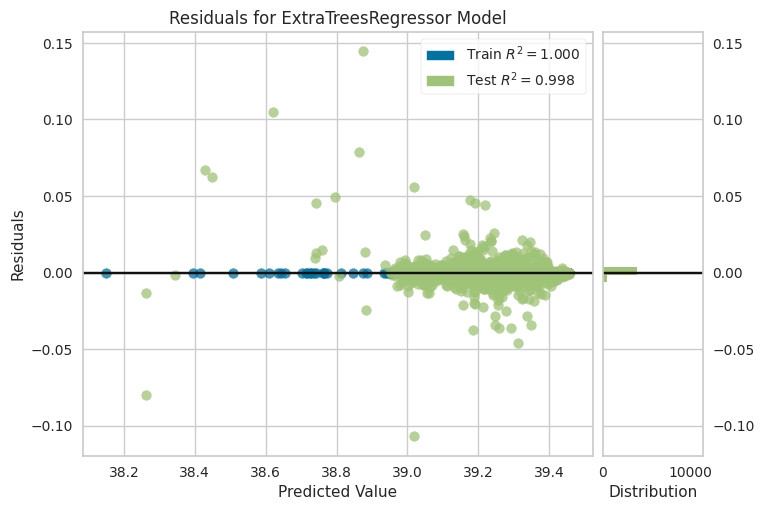

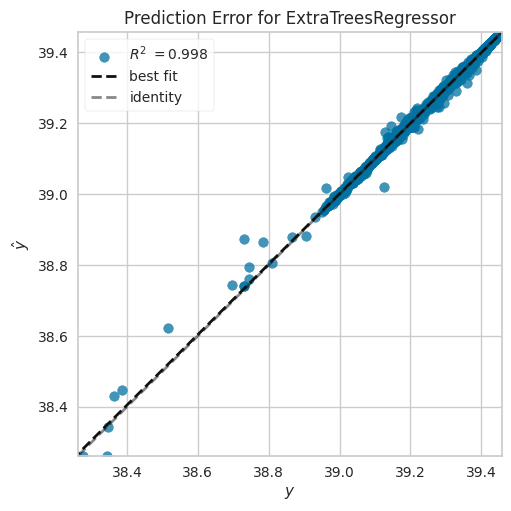

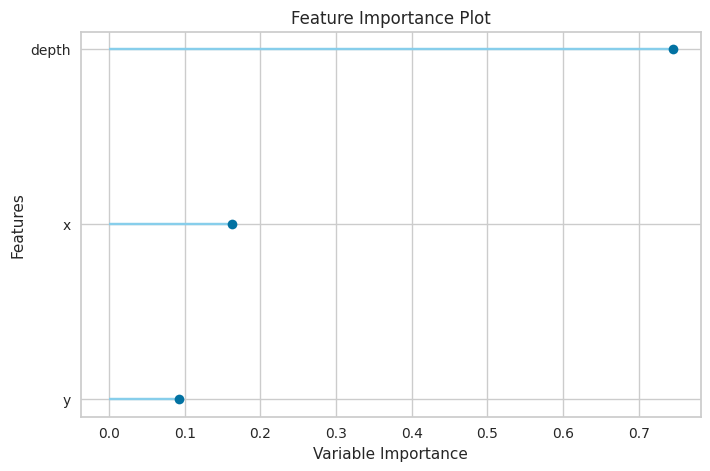

Transformation Pipeline and Model Successfully Saved


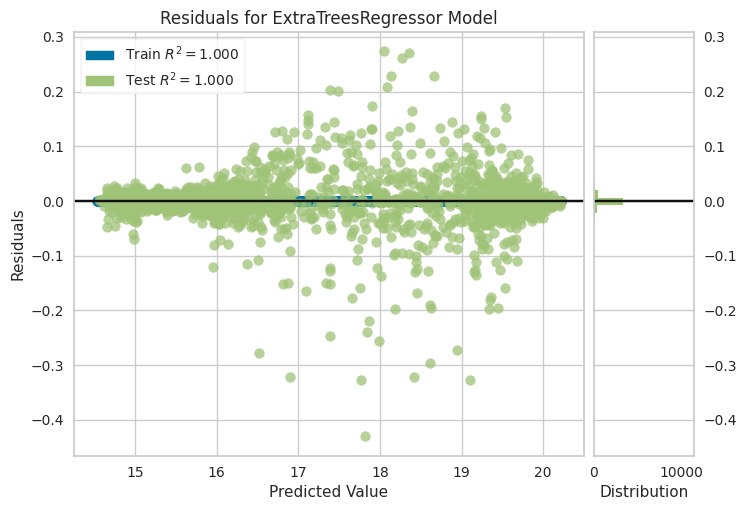

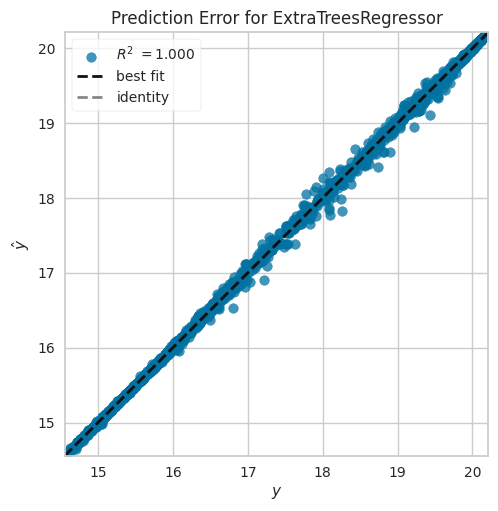

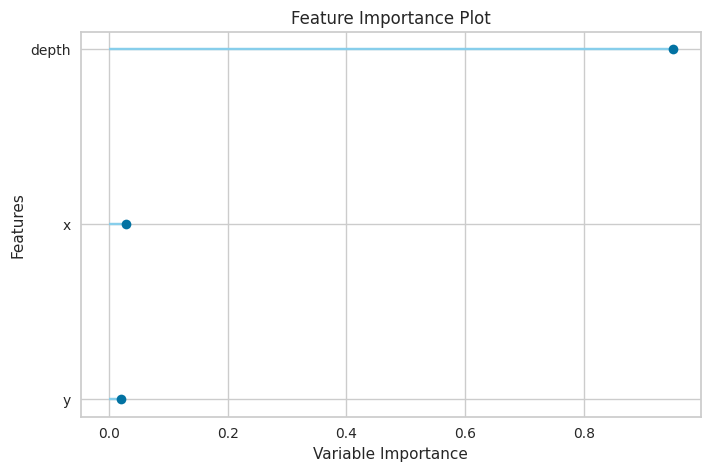

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['depth', 'x', 'y'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=1))]),
 'my_second_pipeline.pkl')

In [8]:
# from pycaret.regression import plot_model

s_reg.plot_model(s_best, plot='residuals')
s_reg.plot_model(s_best, plot='error')
s_reg.plot_model(s_best, plot='feature')
s_reg.save_model(s_best, 'my_first_pipeline')

t_reg.plot_model(t_best, plot='residuals')
t_reg.plot_model(t_best, plot='error')
t_reg.plot_model(t_best, plot='feature')
t_reg.save_model(t_best, 'my_second_pipeline')

In [11]:
v_reg = RegressionExperiment()
v_df = sea_df[['depth', 'x', 'y', 'vo']]
v_reg.setup(v_df, target='vo', session_id=1,
            normalize=True, normalize_method="minmax")
v_best = v_reg.compare_models(budget_time=0.5, include=[
                              'lr', 'dt',  'et', 'rf', 'knn', 'gbr', 'ada', 'svm', 'xgboost'])  # 'lightgbm',


u_reg = RegressionExperiment()
u_df = sea_df[['depth', 'x', 'y', 'uo']]
u_reg.setup(u_df, target='uo', session_id=1,
            normalize=True, normalize_method="minmax")
u_best = u_reg.compare_models(budget_time=0.5, include=[
                              'lr', 'dt',  'et', 'rf', 'knn', 'gbr', 'ada', 'svm', 'xgboost'])  # 'lightgbm',

,Description,Value
0,Session id,1
1,Target,vo
2,Target type,Regression
3,Original data shape,"(15624, 4)"
4,Transformed data shape,"(15624, 4)"
5,Transformed train set shape,"(10936, 4)"
6,Transformed test set shape,"(4688, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0010,0.0000,0.0023,0.9983,0.0021,0.2734,0.1040
rf,Random Forest Regressor,0.0013,0.0000,0.0028,0.9974,0.0026,0.3591,0.1290
xgboost,Extreme Gradient Boosting,0.0024,0.0000,0.0035,0.9958,0.0033,0.6467,0.0150
dt,Decision Tree Regressor,0.0018,0.0000,0.0039,0.9950,0.0036,0.4261,0.0080
knn,K Neighbors Regressor,0.0024,0.0000,0.0043,0.9939,0.0039,0.5307,0.0080
gbr,Gradient Boosting Regressor,0.0130,0.0003,0.0171,0.9029,0.0153,2.5654,0.0480
ada,AdaBoost Regressor,0.0206,0.0006,0.0252,0.7874,0.0218,5.0886,0.0360
lr,Linear Regression,0.0339,0.0019,0.0433,0.3761,0.0356,7.0136,0.0070
svm,Support Vector Regression,0.0395,0.0021,0.0456,0.3051,0.0380,13.8665,0.0070


,Description,Value
0,Session id,1
1,Target,uo
2,Target type,Regression
3,Original data shape,"(15624, 4)"
4,Transformed data shape,"(15624, 4)"
5,Transformed train set shape,"(10936, 4)"
6,Transformed test set shape,"(4688, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0008,0.0000,0.0018,0.9984,0.0017,0.3304,0.1050
rf,Random Forest Regressor,0.0012,0.0000,0.0025,0.9970,0.0023,0.4737,0.1210
dt,Decision Tree Regressor,0.0015,0.0000,0.0034,0.9946,0.0031,0.5107,0.0070
xgboost,Extreme Gradient Boosting,0.0022,0.0000,0.0034,0.9945,0.0031,1.9983,0.0120
knn,K Neighbors Regressor,0.0026,0.0000,0.0048,0.9892,0.0043,1.0244,0.0090
gbr,Gradient Boosting Regressor,0.0097,0.0002,0.0135,0.9144,0.0120,8.8848,0.0470
ada,AdaBoost Regressor,0.0177,0.0005,0.0230,0.7501,0.0197,82.3634,0.0380
svm,Support Vector Regression,0.0312,0.0015,0.0392,0.2742,0.0297,123.1667,0.0070
lr,Linear Regression,0.0278,0.0016,0.0402,0.2417,0.0296,23.5027,0.0060


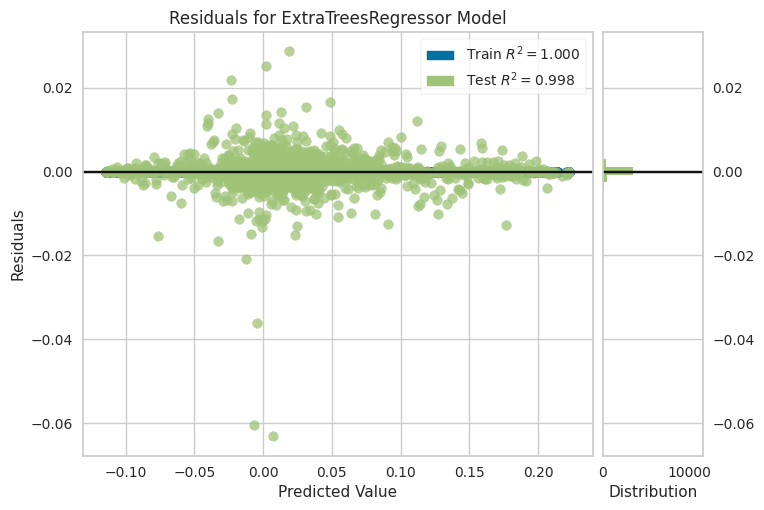

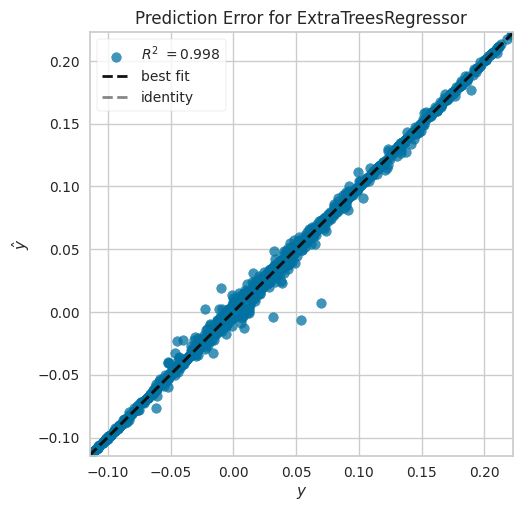

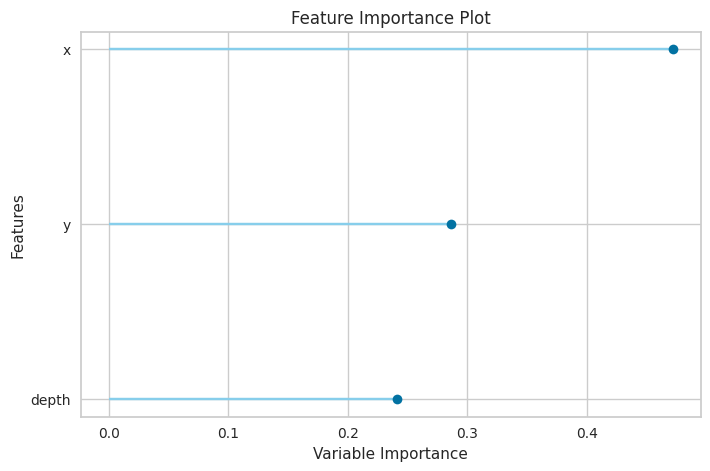

Transformation Pipeline and Model Successfully Saved


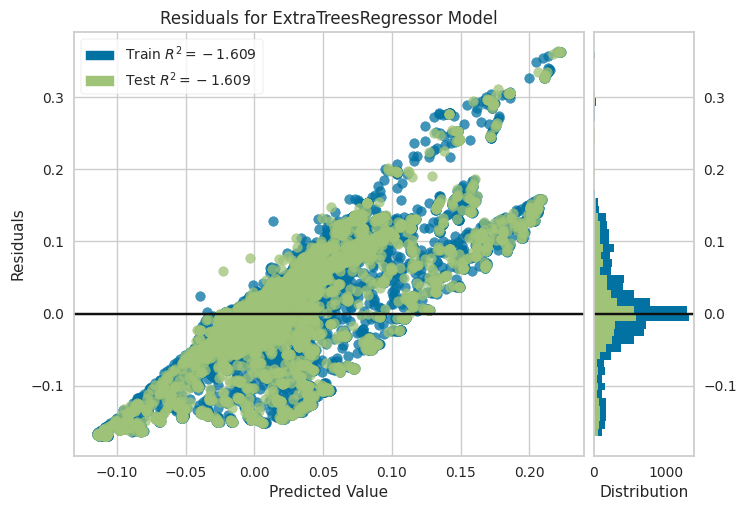

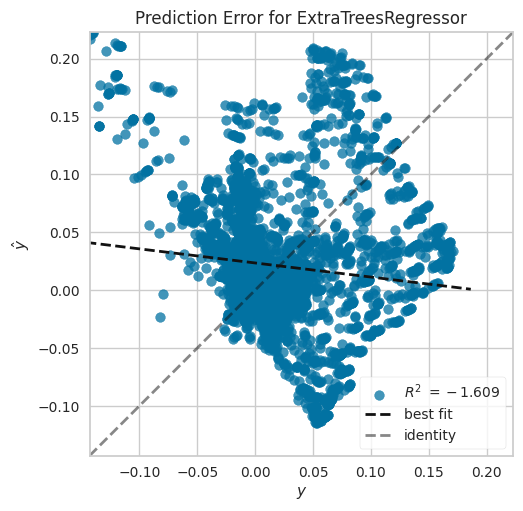

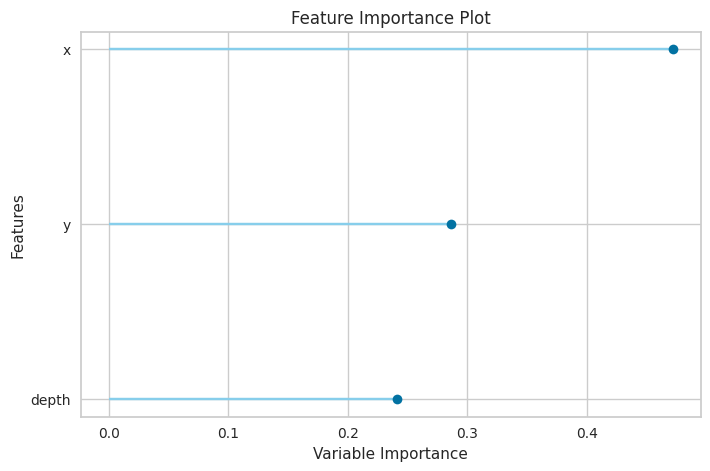

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['depth', 'x', 'y'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=1))]),
 'my_second_pipeline.pkl')

In [12]:
v_reg.plot_model(v_best, plot='residuals')
v_reg.plot_model(v_best, plot='error')
v_reg.plot_model(v_best, plot='feature')
v_reg.save_model(v_best, 'my_second_pipeline')

u_reg.plot_model(v_best, plot='residuals')
u_reg.plot_model(v_best, plot='error')
u_reg.plot_model(v_best, plot='feature')
u_reg.save_model(v_best, 'my_second_pipeline')

In [13]:

models = zip(['so', 'thetao', 'uo', 'vo'], [s_reg, t_reg,
             u_reg, v_reg], [s_best, t_best, u_best, v_best])

# Save the models
for name, reg, best in models:

    path = sample_path.removesuffix('.csv').removesuffix('.csv') + "_" + name
    reg.save_model(best, path)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


In [14]:
# load the models
from pycaret.regression import load_model

best_models = dict()
for name in ['so', 'thetao', 'uo', 'vo']:
    path = sample_path.removesuffix('.csv').removesuffix('.csv') + "_" + name
    best_models[name] = load_model(path)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


### IVP (RK method)


In [22]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import predict_model

# pick a point
nlat = sea_df.iloc[-1]['x']
nlon = sea_df.iloc[-1]['y']
selected_df = sea_df[(sea_df['x'] == sea_df.iloc[-1]['x']) &
                     (sea_df['y'] == sea_df.iloc[-1]['y'])]
print(selected_df.shape)
selected_df.head()

(55, 9)


,depth,lat,lon,uo,vo,thetao,so,x,y
211,1.018237,37.854168,20.583334,-0.034078,0.056541,19.549486,39.298912,0.0,50870.421242
648,3.165747,37.854168,20.583334,-0.034137,0.056459,19.549547,39.298930,0.0,50870.421242
1085,5.464963,37.854168,20.583334,-0.034177,0.056386,19.549595,39.298946,0.0,50870.421242
1522,7.920377,37.854168,20.583334,-0.034201,0.056342,19.549627,39.298958,0.0,50870.421242
1959,10.536604,37.854168,20.583334,-0.034220,0.056311,19.549652,39.298960,0.0,50870.421242


In [25]:
def para_at(x, y, z):
    data = {'depth': [z], 'y': [y], 'x': [x], }
    ndf = pd.DataFrame(data)
    s_df = predict_model(best_models['so'], data=ndf)
    t_df = predict_model(best_models['thetao'], data=ndf)
    return s_df['prediction_label'].iloc[0], t_df['prediction_label'].iloc[0]


para_at(10, 10000, 20)

(39.096470527648925, 19.17222589492798)

In [24]:
# Define the ODE as a function

def ode_system(z, p):
    g_z = g_0 - 3.084e-6*z
    s, t = para_at(nlon, nlat, z)
    return g_z*density(s, t, p)


# Initial condition (x0, y0)
z0 = 0
p0 = [0]  # The initial condition, as a list even if it's only one condition

# Define the range of x values over which to solve the ODE
z_end = selected_df['depth'].iloc[-1]  # Solve from x0 to x_end

# Call the solver
sol = solve_ivp(ode_system, [z0, z_end], p0,
                method='RK45', t_eval=np.linspace(z0, z_end, 100), dense_output=True)

# sol.t is the array of x values
# sol.y is the array of y values. It's a 2D array even if the problem is 1D.


def press(z):
    return sol.sol(z)


def dens(z):
    s, t = para_at(nlon, nlat, z)
    p = press
    return density(s, t, p)

KeyboardInterrupt: 

In [ ]:
# Plotting the result
plt.plot(sol.t, sol.y[0], label='Approximate press')
plt.plot(sol.t, np.ndarray(map(dens, sol.t)), label='Approximate dens')
plt.xlabel('z')
plt.ylabel('P')
plt.title('Pressure w.r.t. Z')
plt.legend()
plt.grid(True)
plt.show()

## Submersible


In [ ]:
import numpy as np

# the equivalent radius of streamline cylinder
R_cy = np.sqrt(width*height)
H_cy = length


def inertia(mass, theta, phi):
    # Convert angles to radians
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)

    # Moments of inertia
    Ixx = (1/12) * mass * (3 * R_cy**2 + H_cy**2)
    Iyy = Ixx
    Izz = (1/2) * mass * R_cy**2

    # Rotation matrix for the given angles
    R = np.array([[np.cos(theta_rad), -np.sin(theta_rad) * np.cos(phi_rad), np.sin(theta_rad) * np.sin(phi_rad)],
                  [np.sin(theta_rad), np.cos(theta_rad) *
                   np.cos(phi_rad), -np.cos(theta_rad) * np.sin(phi_rad)],
                  [0, np.sin(phi_rad), np.cos(phi_rad)]])

    # Transform the inertia tensor to the rotated coordinate system
    I_rotated = np.dot(R.T, np.dot(np.diag([Ixx, Iyy, Izz]), R))

    return I_rotated


def coriolis_force(m, latitude, v):
    """
    Calculates the Coriolis force on an object.

    Parameters:
    m (float): The mass of the object in kilograms.
    latitude (float): The latitude in degrees where the object is located.
    v (tuple): The velocity vector of the object in meters per second, given as (v_eastward, v_northward).

    Returns:
    tuple: The Coriolis force vector given as (F_eastward, F_northward).
    """
    # Earth's rotation rate in rad/s
    omega = 7.2921150e-5

    # Convert latitude to radians
    latitude_rad = np.radians(latitude)

    # Calculate components of the angular velocity vector
    # Assuming that Omega is along the axis of Earth's rotation
    omega_vector = np.array([0, 0, omega * np.cos(latitude_rad)])

    # Convert the velocity vector to a numpy array
    # Assuming horizontal movement, so vertical component is zero
    v_vector = np.array([v[0], v[1], 0])

    # Calculate the Coriolis force
    F_coriolis_vector = -2 * m * np.cross(omega_vector, v_vector)

    # Return the eastward and northward components of the force
    return (F_coriolis_vector[0], F_coriolis_vector[1])


def drag(x, y, z, v):
    pass